In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Path to the file
file_name = 'c101'

file_path = f'Solomon_25/{file_name}.txt'

# Read the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Find the line index where the CUSTOMER data begins
for i, line in enumerate(lines):
    if line.strip().startswith("CUST NO."):
        header_index = i
        break

# Extract header and data
header_line = lines[header_index].split()
data_lines = lines[header_index + 2:]  # Skip the empty line after the header

# Parse the data
data = []
for line in data_lines:
    if line.strip():  # Skip empty lines
        parts = line.split()
        data.append([int(part) for part in parts])

print(np.shape(data))

(101, 7)


In [114]:
print(header_line)

['CUST', 'NO.', 'XCOORD.', 'YCOORD.', 'DEMAND', 'READY', 'TIME', 'DUE', 'DATE', 'SERVICE', 'TIME']


In [115]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['Index', 'X', 'Y', 'Demand', 'Start', 'End', 'Duration'])
df.set_index('Index', inplace=True)

In [116]:
df.head()

,X,Y,Demand,Start,End,Duration
Index,,,,,,
0,40,50,0,0,1236,0
1,45,68,10,912,967,90
2,45,70,30,825,870,90
3,42,66,10,65,146,90
4,42,68,10,727,782,90


We will turn this into a data set suitable for our ``data_loader``.

In [117]:
# add a column for Type
# set Type of the first row as '0'
# for the rest, randomly sample numbers from 1 to 100 and assign them to Type.
# set seed for reproducibility
np.random.seed(42)
df['Event'] = 0
df.loc[1:, 'Event'] = np.random.choice(np.arange(1, 101), size=len(df) - 1, replace=False)
# Display the DataFrame
df.head()

,X,Y,Demand,Start,End,Duration,Event
Index,,,,,,,
0,40,50,0,0,1236,0,0
1,45,68,10,912,967,90,84
2,45,70,30,825,870,90,54
3,42,66,10,65,146,90,71
4,42,68,10,727,782,90,46


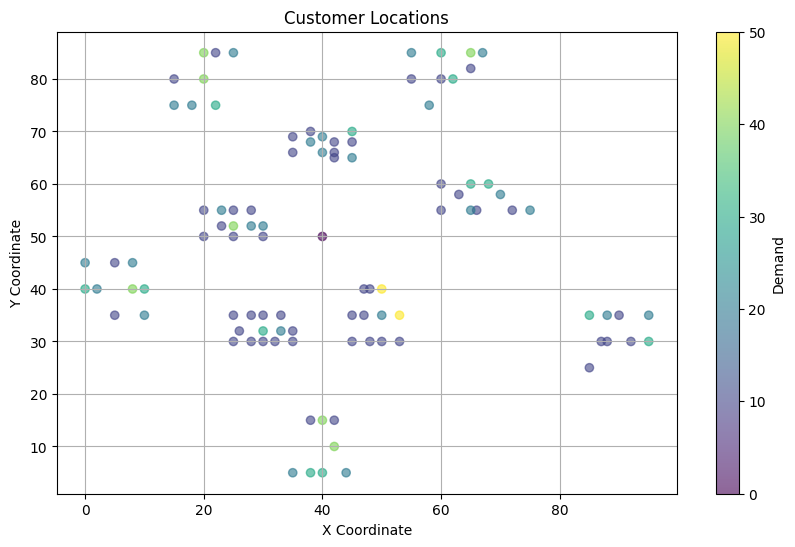

In [118]:
# plot the X and Y coordinates
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['Demand'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Demand')
plt.title('Customer Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid()
plt.show()

We will first create the ``C_travel`` matrix. Recall
```# C_travel has shape (m + n) x (m + 1)
        C_event = C_travel[:m, :m] # m x m matrix
        C_home = C_travel[m:, :m].T # m x n matrix
        C_depot = C_travel[:, -1] # (m+n) x 1 vector

In [119]:
# for those with type value between 1 and 50 (inclusive), create a matrix by fill in the Eucliden distance calculated by X and Y coordinates
def euclidean_distance(row1, row2):
    return np.sqrt((row1['X'] - row2['X']) ** 2 + (row1['Y'] - row2['Y']) ** 2)

In [120]:
# create a distance matrix
C_event = pd.DataFrame(index=df.index, columns=df.index)
for i in df.index:
    for j in df.index:
        if df.loc[i, 'Event'] <= 50 and df.loc[j, 'Event'] <= 50 and df.loc[i, 'Event'] != 0 and df.loc[j, 'Event'] != 0:
            C_event.loc[i, j] = euclidean_distance(df.loc[i], df.loc[j])
        else:
            C_event.loc[i, j] = np.nan  # Fill with NaN for other types

In [121]:
# drop rows and columns with all NaN values
C_event.dropna(how='all', inplace=True)
C_event.dropna(axis=1, how='all', inplace=True)

In [122]:
C_event = C_event.astype(int)
C_event.head()

Index,4,5,6,7,9,10,11,12,14,16,...,74,78,83,84,85,87,88,89,95,98
Index,,,,,,,,,,,,,,,,,,,,,
4,0,3,2,2,4,7,7,24,26,27,...,34,56,32,29,27,26,24,23,23,17
5,3,0,4,2,6,7,8,26,28,29,...,31,54,31,28,26,25,23,22,25,18
6,2,4,0,3,2,5,5,21,24,25,...,36,58,34,31,29,28,26,25,24,18
7,2,2,3,0,4,5,5,24,26,27,...,33,57,33,31,28,27,25,24,26,20
9,4,6,2,4,0,5,3,19,21,23,...,38,61,37,34,31,30,28,27,26,20


Next, consider travel between home and events. 

In [123]:
C_home = pd.DataFrame(index=df.index, columns=df.index)
for i in df.index:
    for j in df.index:
        if df.loc[i, 'Event'] <= 50 and df.loc[j, 'Event'] > 50 and df.loc[i, 'Event'] != 0:
            C_home.loc[i, j] = euclidean_distance(df.loc[i], df.loc[j])
        else:
            C_home.loc[i, j] = np.nan  # Fill with NaN for other types

C_home.dropna(how='all', inplace=True)
C_home.dropna(axis=1, how='all', inplace=True)

C_home = C_home.astype(int)
print(np.shape(C_home))
C_home.head()

(50, 50)


Index,1,2,3,8,13,15,17,18,21,22,...,86,90,91,92,93,94,96,97,99,100
Index,,,,,,,,,,,,,,,,,,,,,
4,3,3,2,4,21,25,25,27,20,21,...,27,22,19,30,28,26,21,24,17,21
5,4,5,1,5,22,26,26,28,17,19,...,26,20,18,32,30,28,23,26,19,23
6,5,5,3,2,18,22,22,25,19,20,...,29,24,21,31,29,28,22,25,18,21
7,5,6,2,2,20,24,23,26,17,18,...,28,22,20,33,31,29,24,27,20,24
9,7,7,5,2,16,20,20,23,19,20,...,31,26,24,32,30,29,24,26,19,22


Finally, get ``C_depot`` (m+n) by 1. 

In [124]:
C_depot = pd.DataFrame(index=df.index, columns=df.index)

for i in df.index:
    if i != 0:
        C_depot.loc[i, 0] = euclidean_distance(df.loc[i], df.loc[0])

C_depot.dropna(how='all', inplace=True)
C_depot.dropna(axis=1, how='all', inplace=True)

C_depot = C_depot.astype(int)
C_depot = C_depot.T
C_depot

Index,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Index,,,,,,,,,,,,,,,,,,,,,
0,18,20,16,18,15,19,16,18,20,16,...,22,44,43,40,37,36,40,30,33,38


Append the matrices to obtain the full dataset. 

In [125]:
# append C_home to the right of C_event by index
C_travel = C_event.join(C_home)
C_travel = pd.concat([C_travel, C_depot], axis=0)
C_travel = C_travel.T

In [126]:
C_travel

Index,4,5,6,7,9,10,11,12,14,16,...,78,83,84,85,87,88,89,95,98,0
Index,,,,,,,,,,,,,,,,,,,,,
4,0,3,2,2,4,7,7,24,26,27,...,56,32,29,27,26,24,23,23,17,18
5,3,0,4,2,6,7,8,26,28,29,...,54,31,28,26,25,23,22,25,18,15
6,2,4,0,3,2,5,5,21,24,25,...,58,34,31,29,28,26,25,24,18,19
7,2,2,3,0,4,5,5,24,26,27,...,57,33,31,28,27,25,24,26,20,16
9,4,6,2,4,0,5,3,19,21,23,...,61,37,34,31,30,28,27,26,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,26,28,28,29,29,34,32,40,43,45,...,52,27,24,22,27,22,24,3,9,40
96,21,23,22,24,24,28,27,35,38,40,...,53,27,24,21,25,20,22,2,5,36
97,24,26,25,27,26,31,29,35,38,40,...,57,32,28,26,30,25,27,5,10,40


Now, ``C_travel`` has shape (m+n, m+1). 

Next, we will create ``C_dur``. 

In [127]:
# extract rows with Event 1 to 50 (inclusive)
C_dur = df[df['Event'] <= 50].copy()
C_dur = C_dur[C_dur['Event'] != 0] 

# drop 'X', 'Y'
C_dur.drop(columns=['X', 'Y'], inplace=True)
C_dur = C_dur.set_index('Event')

# multiply Duration by 3, drio Demand, Start, End
C_dur['Duration'] = C_dur['Duration'] * 2
C_dur.drop(columns=['Demand', 'Start', 'End'], inplace=True)

# sort by index
C_dur = C_dur.sort_index()

C_dur

,Duration
Event,
1,180
2,180
3,180
4,180
5,180
6,180
7,180
8,180
9,180


Set up time windows. 

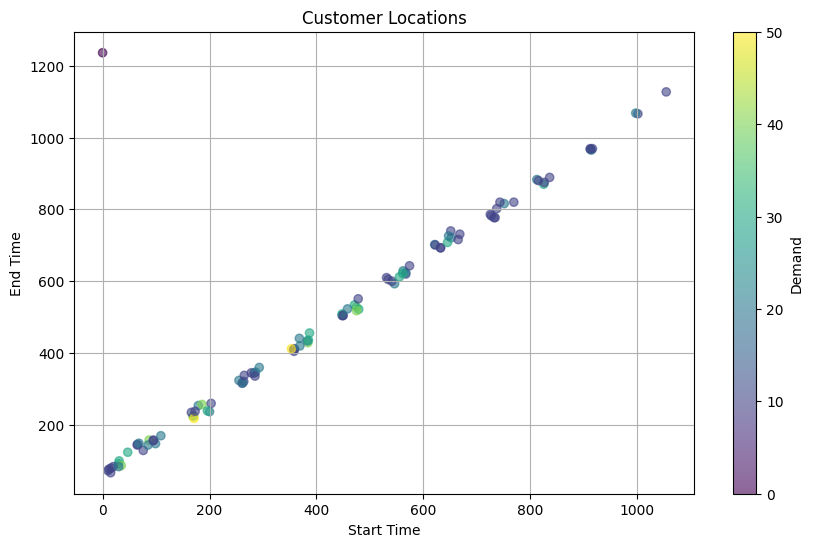

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(df['Start'], df['End'], c=df['Demand'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Demand')
plt.title('Customer Time Windows')
plt.xlabel('Start Time')
plt.ylabel('End Time')
plt.grid()
plt.show()

In [129]:
# extract rows with Type 1 to 50 (inclusive)
Time_Window = df[df['Event'] <= 50].copy()
Time_Window = Time_Window[Time_Window['Event'] != 0] 

# drop irrelavant columns
Time_Window.drop(columns=['X', 'Y', 'Demand', 'Duration'], inplace=True)
Time_Window = Time_Window.set_index('Event')

# sort by index
Time_Window = Time_Window.sort_index()

# add colomns Start_1, End_1, Start_2, End_2, ..., Start_5, End_5
# for each row, if Start is between (i-1)*200 and i*200, then assign 30 to Start_i and 270 to End_i
for i in range(1, 6):
    start_col = f'Start_{i}'
    end_col = f'End_{i}'
    Time_Window[start_col] = 0
    Time_Window[end_col] = 0
    for index, row in Time_Window.iterrows():
        if (i - 1) * 200 <= row['Start'] < i * 200:
            Time_Window.at[index, start_col] = 30
            Time_Window.at[index, end_col] = 270

Time_Window = Time_Window.drop(columns=['Start', 'End'])
# if any row has all Start_i and End_i as 0, then assign 30 to Start_5 and 270 to End_5
if (Time_Window[[f'Start_{i}' for i in range(1, 6)]].sum(axis=1) == 0).any():
    Time_Window.loc[Time_Window[[f'Start_{i}' for i in range(1, 6)]].sum(axis=1) == 0, 'Start_5'] = 30
    Time_Window.loc[Time_Window[[f'Start_{i}' for i in range(1, 6)]].sum(axis=1) == 0, 'End_5'] = 270 

Time_Window

,Start_1,End_1,Start_2,End_2,Start_3,End_3,Start_4,End_4,Start_5,End_5
Event,,,,,,,,,,
1,0,0,30,270,0,0,0,0,0,0
2,0,0,0,0,30,270,0,0,0,0
3,0,0,0,0,0,0,30,270,0,0
4,0,0,0,0,0,0,0,0,30,270
5,0,0,0,0,30,270,0,0,0,0
6,0,0,0,0,0,0,30,270,0,0
7,30,270,0,0,0,0,0,0,0,0
8,30,270,0,0,0,0,0,0,0,0
9,30,270,0,0,0,0,0,0,0,0


Finally, create nurse requirements ``min_nurse``. 

In [130]:

Min_Nurse = df[(df['Event'] <= 50) & (df['Event'] > 0)].copy()
# Min_Nurse = Time_Window[Time_Window['Event'] != 0] 

# drop irrelavant columns
Min_Nurse.drop(columns=['X', 'Y', 'Start', 'End', 'Duration'], inplace=True)
Min_Nurse = Min_Nurse.set_index('Event')


Min_Nurse['RN'] = (Min_Nurse['Demand']/10).astype(int)
np.random.seed(42)
Min_Nurse['LVN'] = Min_Nurse['RN'] + np.random.randint(0, Min_Nurse['RN'] + 1, size=len(Min_Nurse))

Min_Nurse = Min_Nurse.drop(columns=['Demand'])
# sort by index
Min_Nurse = Min_Nurse.sort_index()
Min_Nurse

,RN,LVN
Event,,
1,1,2
2,3,5
3,3,6
4,1,1
5,4,5
6,1,2
7,4,5
8,1,1
9,1,1


Create a dataframe to store parameters.
```
Parameter	Value
nr	20
nl	30
m	50
day	5

In [131]:
Setting = pd.DataFrame({'Parameter': ['nr', 'nl', 'm', 'day'], 
                       'Value': [20, 30, 50, 5]})
Setting

,Parameter,Value
0,nr,20
1,nl,30
2,m,50
3,day,5


Save everything to a multi-sheet xslx file.

In [ ]:
# save data frames to separate sheets of xlsx file
with pd.ExcelWriter(f'{file_name}_data.xlsx') as writer:
    Setting.to_excel(writer, sheet_name='Settings', index=False)
    C_travel.to_excel(writer, sheet_name='C_travel')
    C_dur.to_excel(writer, sheet_name='C_dur')
    Time_Window.to_excel(writer, sheet_name='Time_Window')
    Min_Nurse.to_excel(writer, sheet_name='Min_Nurse')
    